# Step 2: Embedding-based Model

This notebook implements an embedding-based model for predicting human preference of LLM responses.
We will use a pre-trained sentence embedding model to construct prompt+response embeddings and train a classifier.

## 1. Install and Import Libraries

In [3]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import re

c:\Users\user\anaconda3\envs\ML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Data

In [4]:
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
submission_df = pd.read_csv('../dataset/sample_submission.csv')

train_df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


## 3. Prepare Text and Generate Embeddings

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def prepare_text(df):
    # Clean up the prompt column
    df['prompt'] = df['prompt'].apply(lambda x: re.sub(r'[""|""]', '', str(x)))
    df['text_a'] = df['prompt'] + ' ' + df['response_a']
    df['text_b'] = df['prompt'] + ' ' + df['response_b']
    return df

train_df = prepare_text(train_df)
test_df = prepare_text(test_df)

# Generate embeddings
train_embeddings_a = model.encode(train_df['text_a'].tolist(), show_progress_bar=True)
train_embeddings_b = model.encode(train_df['text_b'].tolist(), show_progress_bar=True)
test_embeddings_a = model.encode(test_df['text_a'].tolist(), show_progress_bar=True)
test_embeddings_b = model.encode(test_df['text_b'].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 1/1 [00:00<00:00, 124.37it/s]


## 4. Feature Engineering

In [6]:
# Use the difference between embeddings as features
X = train_embeddings_a - train_embeddings_b
X_test = test_embeddings_a - test_embeddings_b

conditions = [
    train_df['winner_model_a'] == 1,
    train_df['winner_model_b'] == 1,
    train_df['winner_tie'] == 1
]
choices = [0, 1, 2] # 0: model_a, 1: model_b, 2: tie
y = np.select(conditions, choices, default=-1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Model Training

In [7]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## 6. Prediction

In [8]:
predictions = classifier.predict_proba(X_test)

## 7. Submission

In [9]:
submission_df['winner_model_a'] = predictions[:, 0]
submission_df['winner_model_b'] = predictions[:, 1]
submission_df['winner_tie'] = predictions[:, 2]

submission_df.to_csv('submission_embedding.csv', index=False)

submission_df.head()

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.424403,0.233939,0.341658
1,211333,0.251763,0.448705,0.299532
2,1233961,0.327807,0.376889,0.295305


## 8. Evaluation


📊 Validation Accuracy: 0.4094
📉 Validation LogLoss: 1.0704
 F1 macro: 0.363361

Classification Report:
              precision    recall  f1-score   support

       A win       0.41      0.60      0.49      4030
       B win       0.43      0.50      0.46      3929
         Tie       0.33      0.09      0.14      3537

    accuracy                           0.41     11496
   macro avg       0.39      0.40      0.36     11496
weighted avg       0.39      0.41      0.37     11496



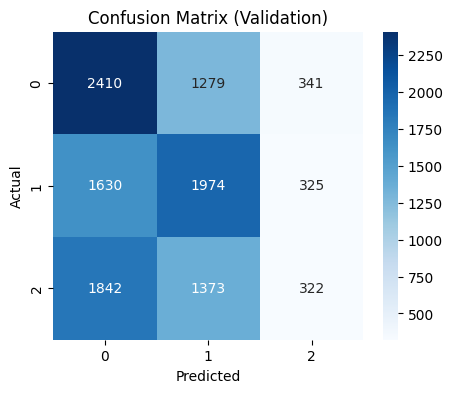

In [10]:
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = classifier.predict(X_val)
y_prob = classifier.predict_proba(X_val)

acc = accuracy_score(y_val, y_pred)
loss = log_loss(y_val, y_prob)
f1 = f1_score(y_val, y_pred, average='macro')

print(f"\n📊 Validation Accuracy: {acc:.4f}")
print(f"📉 Validation LogLoss: {loss:.4f}")
print(f" F1 macro: {f1:4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=["A win", "B win", "Tie"]))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()